<All keys matched successfully>


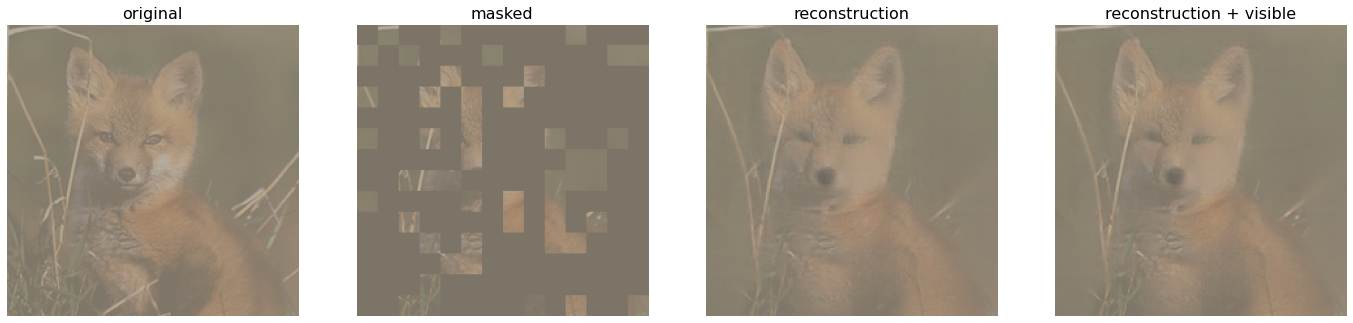

In [2]:
import torch
import sys
sys.path.append('C:/Users/lewa/Documents/PhD/vit/vit-pytorch/')
sys.path.append('C:/Users/lewa/Documents/PhD/vit/mae/')
import models_mae
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
#autoreload python file
%reload_ext autoreload
%autoreload 2

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model


def show_image(image, title=''):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])  
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

chkpt_dir = 'C:/Users/lewa/Documents/PhD/Models/mae_visualize_vit_large_ganloss.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

run_one_image(img, model_mae)

SystemExit: 

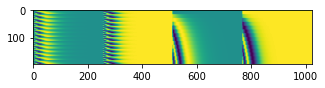

In [20]:
plt.figure(figsize=(5,5))
x = torch.tensor(img)
# make it a batch-like
x = x.unsqueeze(dim=0)
x = torch.einsum('nhwc->nchw', x)
loss, y, mask = model_mae(x.float(), mask_ratio=0.75)

In [8]:
mask.shape

torch.Size([1, 196])